In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.linear_model import LogisticRegression
sns.set(style="white")
from sklearn.externals import joblib



data = pd.read_csv('../fichier_csv/test_billets.csv')

# Standardisation des données

In [2]:
data

,length,height_left,height_right,margin_low,margin_up,diagonal,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [3]:
valeurs = data.iloc[:,[0,1,2,3,4,5]]
etiquettes = data['id']
std_scale = joblib.load('algo_std.pkl')
valeurs_std = std_scale.transform(valeurs)
df_valeurs_std = pd.DataFrame(valeurs_std,columns = ['length', 'height_left', 'height_right', 'margin_low','margin_up','diagonal'])
df_valeurs_std['id'] = etiquettes
data_std = df_valeurs_std.copy()

In [4]:
data_std

,length,height_left,height_right,margin_low,margin_up,diagonal,id
0,0.490087,-0.391356,-0.600347,-0.317295,-0.341212,0.672205,B_1
1,-1.379576,0.348620,0.308729,0.939785,-0.044180,-0.814138,B_2
2,-0.526747,-0.895885,-0.539742,-1.145826,0.295284,0.889190,B_3
3,0.260479,0.045902,0.187519,1.368336,0.549883,-1.595283,B_4
4,-0.493946,0.920419,1.339016,0.554090,-0.426078,-0.759892,B_5


# Test de détection des billets

In [5]:
data_acp = data.copy()
data_acp_ind = data.copy()
data_acp.index = data_acp['id']
del data_acp['id']

X = data_acp.values
n_components = 2

pca = PCA(n_components=n_components)
reduction = pca.fit_transform(X)

for i in range(0, n_components):
    data_acp_ind['PC' + str(i + 1)] = reduction[:, i]


In [6]:
data_acp_ind

,length,height_left,height_right,margin_low,margin_up,diagonal,id,PC1,PC2
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,1.027417,-0.197680
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,-0.654854,0.160489
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,1.523391,0.021478
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,-1.372895,-0.333826
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,-0.523059,0.349540


In [7]:
data_test = data_std.copy()
data_test_ind = data_std.copy()
data_test.index = data_test['id']
del data_test['id']

X = data_test.values

In [8]:
clf2 = joblib.load('algo_reg_log_2.pkl')

probaClasses = clf2.predict_proba(X)

a = pd.Series(probaClasses[:,1],name='probas')
test =pd.concat([data,a],axis=1)

test['verif']=test['probas'] >=0.5
test

,length,height_left,height_right,margin_low,margin_up,diagonal,id,probas,verif
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.965991,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.047384,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.988248,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0.002983,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.111769,False


# Graphique 

[Text(0,0.5,'PC2'), Text(0.5,0,'PC1'), None]

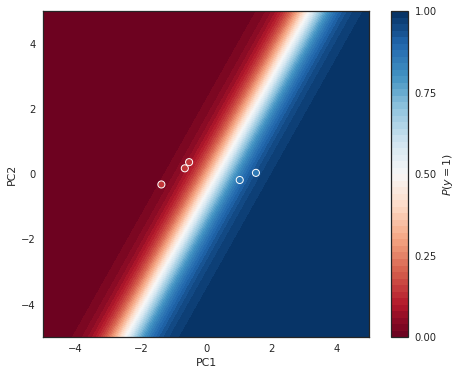

In [12]:
#Regression 
y = test['verif']
clf = joblib.load('algo_reg_log_plot_2.pkl')

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]


probs = clf.predict_proba(grid)[:,0].reshape(xx.shape) 

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs,50, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(data_acp_ind['PC1'], data_acp_ind['PC2'], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",

       xlabel="PC1", ylabel="PC2")